In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, cohen_kappa_score, precision_recall_curve)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from scipy.stats import norm



In [12]:
## function

def AUC_CI(auc, label, alpha = 0.05):
    label = np.array(label)#防止label不是array类型
    n1, n2 = np.sum(label == 1), np.sum(label == 0)
    q1 = auc / (2-auc)
    q2 = (2 * auc ** 2) / (1 + auc)
    se = np.sqrt((auc * (1 - auc) + (n1 - 1) * (q1 - auc ** 2) + (n2 -1) * (q2 - auc ** 2)) / (n1 * n2))
    confidence_level = 1 - alpha
    z_lower, z_upper = norm.interval(confidence_level)
    lowerb, upperb = auc + z_lower * se, auc + z_upper * se
    return (lowerb, upperb)


def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR

    Youden_index = np.argmax(y)  # Only the first occurrence is returned.

    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

def Find_Optimal_Cutoff_bythresh(patient_avg_pred_all, patient_label_all, thresholds):
    youden_max = 0
    best_thresh = -1
    for i in range(thresholds.shape[0]):
        
        try_thresh = thresholds[i]

        opt_bi_pred = np.zeros_like(patient_avg_pred_all)
        opt_bi_pred[patient_avg_pred_all > try_thresh] = 1
        # opt_bi_pred[patient_avg_pred_all <= try_thresh] = 0

        opt_rec = recall_score(patient_label_all, opt_bi_pred)
        opt_confuse = confusion_matrix(patient_label_all, opt_bi_pred, labels=[1,0])
        opt_spc = opt_confuse[1, 1]/(opt_confuse[1, 0] + opt_confuse[1, 1])

        
        fpr = 1 - opt_spc
        tpr = opt_rec

        if 1-tpr == 0 :
            continue
            
        youden_index  = tpr - fpr
        # print(try_thresh, youden_index, opt_confuse[0, 0], opt_confuse[0, 1], opt_confuse[1, 0], opt_confuse[1, 1])

        if youden_index > youden_max:
            youden_max = youden_index
            best_thresh = try_thresh
    return youden_max, best_thresh

def opt_auc_save_patient(test_log_dir, fold, label, predict, curve_auc):

    fpr, tpr, _ = roc_curve(label, predict)
    ## opt AUC curve
    line_width = 1  # 曲线的宽度
    print(f'AUC = {round(curve_auc, 4)}')
    plt.figure(figsize=(8, 5))  # 图的大小
    plt.plot(fpr, tpr, lw=line_width, label=f'AUC = {round(curve_auc, 4)}', color='red')
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.savefig(f'{test_log_dir}patientlevel_ROC_fold{fold}.jpg' , dpi=256)#bbox_inches='tight', pad_inches=0, 

# Patient level evaluation for each folds

In [13]:
eval = 'acc'
exp_name_all = [
            f'/mnt/ExtData/workspace/pahsos/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2023-09-27T11:00:25', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2023-09-27T11:00:30', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc_2023-09-27T11:00:37', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block160_new_2023-03-10T23:36:42/test_bestacc_2023-09-27T11:00:43'
            ]


for exp_name in exp_name_all:
    print(f'Doing -- {exp_name}')
    path = f'{exp_name}/test_block_pred.csv'
    df = pd.read_csv(path)
    name = np.array(df['name'])
    label = np.array(df['label'])
    pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
    all = np.array(df)

    save_path = exp_name
    for fold in range(5):

        total_label = []
        total_avg_predict = []
        total_bi_avg_predict = []

        f = open(f"{exp_name}/test_patient_pred.txt","a") 
        if fold == 0:
            f.write(f'fold, patient_name, patient_label, avg_pred\r\n')

        for patient_num in range(int(len(name)/12)):
            patient_label = label[int(patient_num*12)]
            patient_name = name[int(patient_num*12)]

            # 计算12个block概率值均值
            avg_pred = 0
            for block_num in range(12):
                avg_pred += pred[patient_num*12 + block_num, fold]
            avg_pred = avg_pred / 12

            total_label.append(float(patient_label))
            total_avg_predict.append(avg_pred)
            # total_bi_avg_predict.append(binary_pred)
            f.write(f'{fold}, {patient_name}, {patient_label}, {avg_pred}\r\n')
        f.close()

        total_label = np.array(total_label)
        total_avg_predict = np.array(total_avg_predict)
        total_bi_avg_predict = np.array(total_bi_avg_predict)

        fold_auc = roc_auc_score(total_label, total_avg_predict)
        print(f'AUC of fold {fold}: {fold_auc}')

        f = open(f"{exp_name}/test_patient_auc.txt","a") 
        f.write(f'fold {fold}: {fold_auc}\r\n')
        f.close()
    # break


        
    
            # binary_pred : 使用0.5二值化均值
            # if avg_pred >= 0.5:
            #     binary_pred = 1
            # else:
            #     binary_pred = 0



Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2023-09-27T11:00:25
AUC of fold 0: 0.978448275862069
AUC of fold 1: 0.9655172413793104
AUC of fold 2: 0.9612068965517242
AUC of fold 3: 0.9698275862068966
AUC of fold 4: 0.9698275862068966
Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2023-09-27T11:00:30
AUC of fold 0: 0.9698275862068966
AUC of fold 1: 0.9612068965517241
AUC of fold 2: 0.9870689655172414
AUC of fold 3: 0.9482758620689654
AUC of fold 4: 0.9741379310344828
Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc_2023-09-27T11:00:37
AUC of fold 0: 0.9655172413793104
AUC of fold 1: 0.9612068965517241
AUC of fold 2: 0.9870689655172414
AUC of fold 3: 0.9482758620689655
AUC of fold 4: 0.9568965517241379
Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block160_new_2023-03-10T23:36:42/test_bestacc_2023-09-27T11:00:

# ensemble evaluation 


### 1. 计算病人block预测概率均值




- 读取test block级别预测概率 pred.csv

- 读取根据val计算出的各个fold的最佳阈值 result.csv

！ 请检查测试集数据没有被打乱且每个病人均有12个block，否则需要修改

### block level

In [14]:
import os
exp_name_all = [f'/mnt/ExtData/workspace/pahsos/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2023-09-27T11:00:25', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2023-09-27T11:00:30', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc_2023-09-27T11:00:37', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block160_new_2023-03-10T23:36:42/test_bestacc_2023-09-27T11:00:43']

for exp_name in exp_name_all:
    print(f'Doing -- {exp_name}')
    path = f'{exp_name}/test_block_pred.csv'
    df = pd.read_csv(path)
    name = np.array(df['name'])
    label = np.array(df['label'])
    pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
    all = np.array(df)

    save_path = f'{exp_name}'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    avg_pred = np.mean(pred, axis=1)

    bi_pred = np.zeros_like(avg_pred)
    bi_pred[avg_pred > 0.5] = 1

    acc = accuracy_score(label, bi_pred)
    f1 = f1_score(label, bi_pred, zero_division=1)
    pre = precision_score(label, bi_pred, zero_division=1)
    rec = recall_score(label, bi_pred, zero_division=1)
    confuse = confusion_matrix(label, bi_pred, labels=[1,0])
    spc = confuse[1, 1]/(confuse[1, 0] + confuse[1, 1])

    auc = roc_auc_score(label, avg_pred)
    fpr = 1 - spc
    tpr = rec
    youden_index  = tpr - fpr

    # kappa
    total_num = confuse[0, 0] + confuse[1, 1] + confuse[0, 1] + confuse[1, 0]

    p0 = (confuse[0, 0] + confuse[1, 1]) / total_num
    pe = ((confuse[0, 0] + confuse[1, 0]) * (confuse[0, 0] + confuse[0, 1]) + (confuse[0, 1] + confuse[1, 1]) * (confuse[1, 0] + confuse[1, 1])) / (total_num * total_num)
    kappa = (p0 - pe) / (1 - pe)

    tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
    ci95_upper = kappa + tmp
    ci95_lower = kappa - tmp

    u = kappa / (np.sqrt(p0 / total_num))

    print(f'auc : {auc}, acc : {acc}, rec : {rec}, spc : {spc}')

    f = open(f"{save_path}/resemble_block.txt","a") 
    f.write(f'auc, youdenindex, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')
    f.write(f'{auc}, {youden_index}, {acc}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
    f.close()


Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2023-09-27T11:00:25
auc : 0.9552502394636015, acc : 0.9099099099099099, rec : 0.75, spc : 0.9540229885057471
Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2023-09-27T11:00:30
auc : 0.9601293103448276, acc : 0.918918918918919, rec : 0.8541666666666666, spc : 0.9367816091954023
Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc_2023-09-27T11:00:37
auc : 0.9584231321839081, acc : 0.9234234234234234, rec : 0.78125, spc : 0.9626436781609196
Doing -- /mnt/ExtData/workspace/pahsos/classification/log/block160_new_2023-03-10T23:36:42/test_bestacc_2023-09-27T11:00:43
auc : 0.9643797892720307, acc : 0.9234234234234234, rec : 0.78125, spc : 0.9626436781609196


### 2. 计算病人patient level结果



- find optimal thresh 

In [16]:
import os
eval = 'acc'
exp_name_all = [
            f'/mnt/ExtData/workspace/pahsos/classification/log/block64_new_2023-03-08T21:35:22/test_bestacc_2023-09-27T11:00:25', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block96_new_2023-03-09T15:40:03/test_bestacc_2023-09-27T11:00:30', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block128_new_2023-03-10T14:09:58/test_bestacc_2023-09-27T11:00:37', \
            f'/mnt/ExtData/workspace/pahsos/classification/log/block160_new_2023-03-10T23:36:42/test_bestacc_2023-09-27T11:00:43'
            ]

for exp_name in exp_name_all:
    path = f'{exp_name}/test_block_pred.csv'
    df = pd.read_csv(path)
    name = np.array(df['name'])
    label = np.array(df['label'])
    pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
    all = np.array(df)

    save_path = f'{exp_name}'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    given_thresh = 0.5
    avg_pred = np.mean(pred, axis=1)
    patient_avg_pred_all = []
    patient_label_all = []

    for i in range(len(name)):
        if i % 12 ==0:
            patient_name = name[i]
            patient_label_all.append(label[i])
            # print(patient_name)
            patient_pred = 0
        else:
            assert name[i] == patient_name
            patient_pred += avg_pred[i]

            if i % 11 == 0:
                patient_avg_pred = patient_pred / 12
                patient_avg_pred_all.append(patient_avg_pred)

    patient_label_all = np.array(patient_label_all)
    patient_avg_pred_all = np.array(patient_avg_pred_all)

    precision, recall, thresholds = precision_recall_curve(patient_label_all, patient_avg_pred_all)

    youden_max, best_thresh = Find_Optimal_Cutoff_bythresh(patient_avg_pred_all, patient_label_all, thresholds)
    f = open(f"{save_path}/resemble_patient_optthresh.txt","a") 
    f.write(f'thresh, auc, acc, pre, rec, spc, tp, fn, fp, tn, kappa, p0, pe, ci95, u\r\n')

    opt_bi_pred = np.zeros_like(patient_avg_pred_all)
    opt_bi_pred[patient_avg_pred_all > best_thresh] = 1

    opt_acc = accuracy_score(patient_label_all, opt_bi_pred)
    opt_f1 = f1_score(patient_label_all, opt_bi_pred, zero_division=1)
    opt_pre = precision_score(patient_label_all, opt_bi_pred, zero_division=1)
    opt_rec = recall_score(patient_label_all, opt_bi_pred, zero_division=1)
    opt_confuse = confusion_matrix(patient_label_all, opt_bi_pred, labels=[1,0])
    opt_spc = opt_confuse[1, 1]/(opt_confuse[1, 0] + opt_confuse[1, 1])
    
    auc = roc_auc_score(patient_label_all, patient_avg_pred_all)
    fpr = 1 - opt_spc
    tpr = opt_rec
    youden_index  = tpr - fpr

    # kappa
    total_num = opt_confuse[0, 0] + opt_confuse[1, 1] + opt_confuse[0, 1] + opt_confuse[1, 0]

    p0 = (opt_confuse[0, 0] + opt_confuse[1, 1]) / total_num
    pe = ((opt_confuse[0, 0] + opt_confuse[1, 0]) * (opt_confuse[0, 0] + opt_confuse[0, 1]) + (opt_confuse[0, 1] + opt_confuse[1, 1]) * (opt_confuse[1, 0] + opt_confuse[1, 1])) / (total_num * total_num)
    kappa = (p0 - pe) / (1 - pe)

    tmp = 1.96 * np.sqrt((p0)/(total_num*(1-p0)))
    ci95_upper = kappa + tmp
    ci95_lower = kappa - tmp

    u = kappa / (np.sqrt(p0 / total_num))

    print(f'auc : {auc}, acc : {opt_acc}, rec : {opt_rec}, spc : {opt_spc}, youden : {youden_index}')
    f.write(f'{best_thresh}, {auc}, {opt_acc}, {opt_pre}, {opt_rec}, {opt_spc}, {opt_confuse[0, 0]}, {opt_confuse[0, 1]}, {opt_confuse[1, 0]}, {opt_confuse[1, 1]}, {kappa}, {p0}, {pe}, {[ci95_lower, ci95_upper]}, {u}\r\n')
    f.close()


auc : 0.853448275862069, acc : 0.918918918918919, rec : 0.75, spc : 0.9655172413793104, youden : 0.7155172413793104
auc : 0.9439655172413793, acc : 0.8648648648648649, rec : 0.875, spc : 0.8620689655172413, youden : 0.7370689655172413
auc : 0.9267241379310346, acc : 0.918918918918919, rec : 0.75, spc : 0.9655172413793104, youden : 0.7155172413793104
auc : 0.9353448275862069, acc : 0.8648648648648649, rec : 0.875, spc : 0.8620689655172413, youden : 0.7370689655172413


## visualization

In [9]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.metrics import auc, roc_curve
import numpy as np

eval = 'acc'
exp1_path = f'/mnt/ExtData/pahsos/classification/log/block64_new_2023-03-08T21:35:22/test_best{eval}/'
exp2_path = f'/mnt/ExtData/pahsos/classification/log/block96_new_2023-03-09T15:40:03/test_best{eval}/'
exp3_path = f'/mnt/ExtData/pahsos/classification/log/block128_new_2023-03-10T14:09:58/test_best{eval}/'
exp4_path = f'/mnt/ExtData/pahsos/classification/log/block160_new_2023-03-10T23:36:42/test_best{eval}/'


block_size = [64, 96, 128, 160]
exps = [exp1_path, exp2_path, exp3_path, exp4_path]    
color = ['orange', 'blue', 'green', 'red']


#### block level

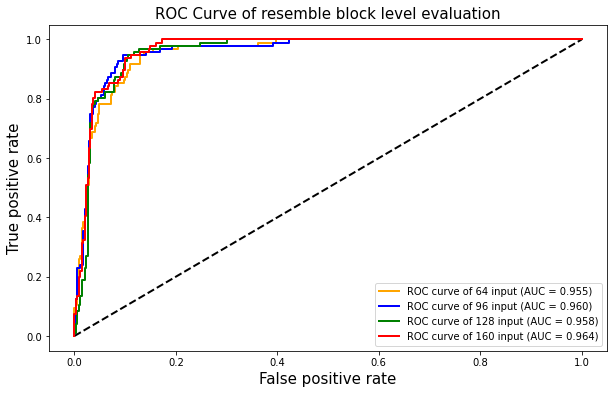

In [10]:
plt.figure(figsize=(10, 6))
plt.title(f'ROC Curve of resemble block level evaluation', fontdict={"family": "Times New Roman", "size": 15})
plt.plot([0, 1], [0, 1], lw=2, color='black', linestyle="--")
plt.xlabel('False positive rate', fontdict={"family": "Times New Roman", "size": 15})
plt.ylabel('True positive rate', fontdict={"family": "Times New Roman", "size": 15})

for i, path in enumerate(exps):
    block_pred_info = pd.read_csv(os.path.join(path, 'test_block_pred.csv'))

    

    label = block_pred_info['label']
    pred = np.stack((block_pred_info['pred0'], block_pred_info['pred1'], block_pred_info['pred2'], block_pred_info['pred3'], block_pred_info['pred4']), axis=1)
    avg_pred = np.mean(pred, axis=1)
    fpr, tpr, _ = roc_curve(label, avg_pred)
    plt.plot(fpr, tpr, lw=2, color=color[i], label=f'ROC curve of {block_size[i]} input (AUC = %0.3f)' % auc(fpr, tpr))

    plt.grid()  # 在图中添加网格

    plt.legend(loc="lower right") 
plt.savefig(os.path.join('/mnt/ExtData/pahsos/classification/new_fig', f'5in1_ROC_blocklevel_resemble_{eval}.jpg'), dpi=256)


### patient level

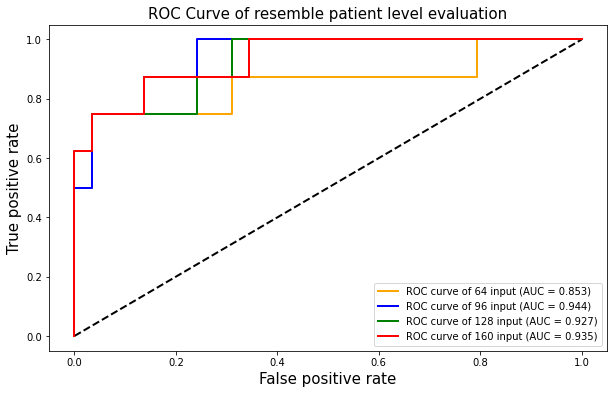

In [11]:
plt.figure(figsize=(10, 6))
plt.title(f'ROC Curve of resemble patient level evaluation', fontdict={"family": "Times New Roman", "size": 15})
plt.plot([0, 1], [0, 1], lw=2, color='black', linestyle="--")
plt.xlabel('False positive rate', fontdict={"family": "Times New Roman", "size": 15})
plt.ylabel('True positive rate', fontdict={"family": "Times New Roman", "size": 15})

for j, path in enumerate(exps):
    block_pred_info = pd.read_csv(os.path.join(path, 'test_block_pred.csv'))
    name = np.array(block_pred_info['name'])
    label = block_pred_info['label']
    pred = np.stack((block_pred_info['pred0'], block_pred_info['pred1'], block_pred_info['pred2'], block_pred_info['pred3'], block_pred_info['pred4']), axis=1)
    
    avg_pred = np.mean(pred, axis=1)
    patient_avg_pred_all = []
    patient_label_all = []

    for i in range(len(name)):
        if i % 12 ==0:
            patient_name = name[i]
            patient_label_all.append(label[i])
            # print(patient_name)
            patient_pred = 0
        else:
            assert name[i] == patient_name
            patient_pred += avg_pred[i]

            if i % 11 == 0:
                patient_avg_pred = patient_pred / 12
                patient_avg_pred_all.append(patient_avg_pred)

    patient_label_all = np.array(patient_label_all)
    patient_avg_pred_all = np.array(patient_avg_pred_all)

    fpr, tpr, _ = roc_curve(patient_label_all, patient_avg_pred_all)
    plt.plot(fpr, tpr, lw=2, color=color[j], label=f'ROC curve of {block_size[j]} input (AUC = %0.3f)' % auc(fpr, tpr))

    plt.grid()  # 在图中添加网格

    plt.legend(loc="lower right") 
plt.savefig(os.path.join('/mnt/ExtData/pahsos/classification/new_fig', f'5in1_ROC_patientlevel_resemble_{eval}.jpg'), dpi=256)
